In [1]:
import matplotlib.pyplot as plt
import cv2

In [2]:
img = cv2.imread('../input/model-architecture/Architecture.png')

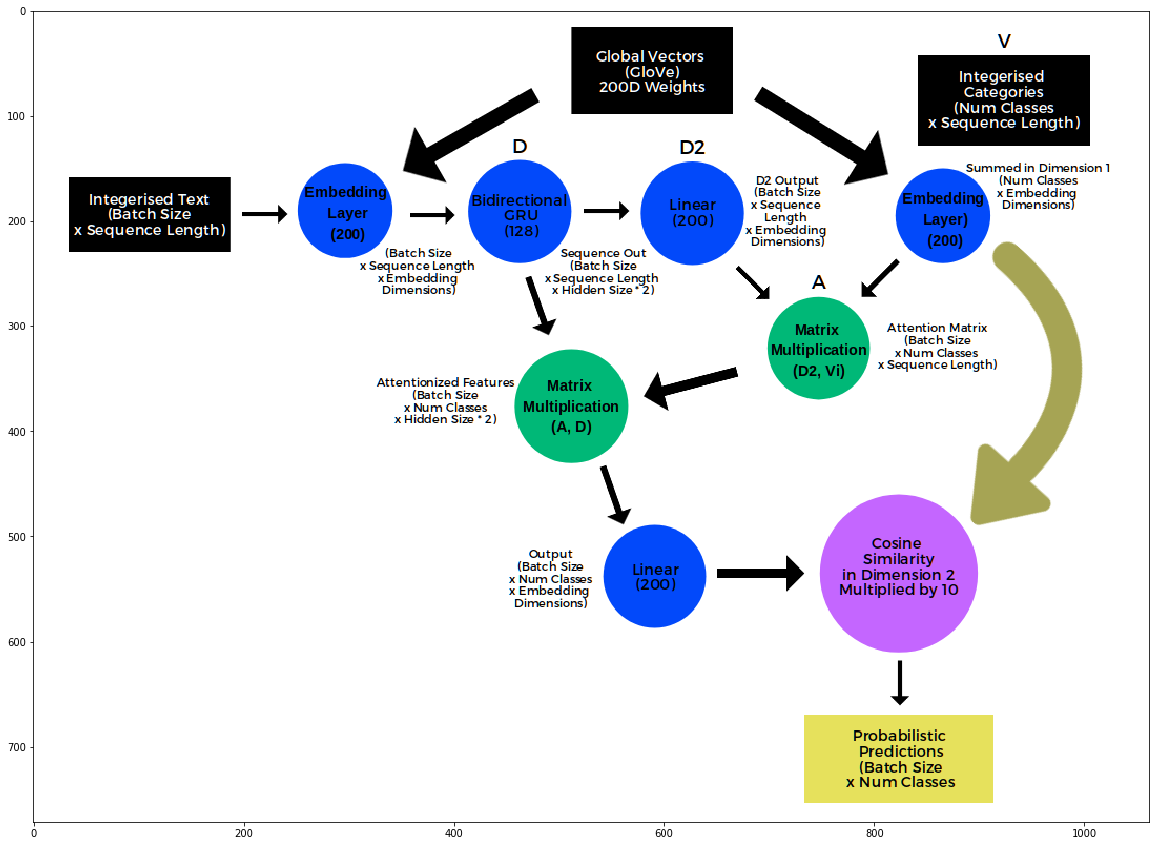

In [3]:
fig = plt.figure(figsize=(20,15))
plt.imshow(img);

In [4]:
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import numpy as np
import pandas as pd
import csv
import json
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.metrics import confusion_matrix

print(torch.__version__)

['beauty-weights', 'fashion-weights', 'mobile-weights', 'ndsc-advanced', 'glove6b200d', 'model-architecture']
1.0.1.post2


In [5]:
os.listdir('../input/beauty-weights/')

['Skin_type', 'Benefits', 'Product_texture', 'Colour_group', 'Brand']

In [6]:
class Pipeline:
    def __init__(self, name, data, profiles, emb_dim):
        self.name = name
        self.data = data
        self.profiles = profiles
        self.emb_dim = emb_dim
        
        self.corpus= self.data['title']
        self.occurences = self.count_words(self.corpus)
        self.vocab, self.vocab_list = self.build_condensed_vocab(self.occurences)
        self.labels = self.build_labels(profiles)
        self.vocab, self.vocab_list, self.int_labels = self.process_labels(self.labels, self.vocab, self.vocab_list)
        self.vocab_size = len(self.vocab_list) + 1 # for 0 to emb to [0 ... 0]
        self.int_corpus = self.integerize(self.corpus)
        self.padded_corpus, self.padded_labels = self.pad_sequences(self.int_corpus, self.int_labels)
        self.seq_len = len(self.int_corpus[0])
        
        self.embedding_matrix = self.build_embedding_matrix(self.vocab_list)
        
        self.num_attributes = len(profiles)
        self.attributes = list(self.profiles.keys())
        self.num_classes = [len(self.profiles[key])+1 for key in self.attributes]
       
        self.training_labels = [np.array(self.data[col].fillna(-1)) for i, col in enumerate(self.attributes)]
    
    
    def count_words(self, corpus):
        occurences = {}
        for sentence in corpus:
            tokens = sentence.split()
            for word in tokens:
                if word not in occurences:
                    occurences[word] = 1
                else:
                    occurences[word] += 1
        return occurences
    
    def build_condensed_vocab(self, occurences):
        for word in occurences:
            if occurences[word] < 3:
                occurences[word] = '<UNKNOWN>'
        
        vocab = {}    
        vocab_list = []
        count = 1 #Starts at 1, where 0 is for padding
        for word in occurences:
            if occurences[word] != '<UNKNOWN>':
                vocab[word] = count
                vocab_list.append(word)
                count += 1
        vocab['<UNKNOWN>'] = count
        vocab_list.append('<UNKNOWN>')
        return vocab, vocab_list
    
    def build_labels(self, profiles):    
        att = profiles.keys()
        labels = []
        for key in att:
            temp_dict = profiles[key]
            temp_labels = [k for k in sorted(temp_dict, key=temp_dict.get, reverse=False)]
            labels.append(temp_labels)
        return labels
            
    def process_labels(self, labels, vocab, vocab_list):
        int_labels = []
        count = len(self.vocab) + 1
        for line in labels:
            temp_labels = []
            for string in line:
                try:
                    splitted = string.split(" ")
                    temp = []
                    for word in splitted:
                        try:
                            temp.append(self.vocab[word])
                        except KeyError:
                            self.vocab[word] = count
                            self.vocab_list.append(word)
                            count += 1
                            temp.append(self.vocab[word])
                    temp_labels.append(temp)
                except:
                    try:
                        temp_labels.append([self.vocab[string]])
                    except KeyError:
                        self.vocab[string] = count
                        self.vocab_list.append(string.lower())
                        count += 1
                        temp_labels.append([self.vocab[string]])
            int_labels.append(temp_labels)
        return vocab, vocab_list, int_labels                      
    
    def integerize(self, corpus, text=True):
        features = []
        for sentence in corpus:
            temp = []
            if text:
                tokens = sentence.split()
            else:
                tokens = sentence
            for word in tokens:
                try:
                    temp.append(self.vocab[word])
                except KeyError:
                    temp.append(self.vocab['<UNKNOWN>'])
            features.append(temp)
        return features
    
    def pad_sequences(self, corpus, labels):
        #Corpus
        maximum = 0
        padded_corpus = []
        temp = corpus
        for sentence in temp:
            if len(sentence) > maximum:
                maximum = len(sentence)
        if maximum % 2 != 0:
            maximum += 1 #Make it Even
        
        for sentence in temp:
            while len(sentence) < maximum:
                sentence.insert(0, 0)
            padded_corpus.append(np.array(sentence))
            
        #Labels
        
        padded_labels = []
        temp = labels
        for line in labels:
            maximum = 0
            temp_items = []
            for item in line:
                if len(item) > maximum:
                    maximum = len(item)
            for item in line:
                while len(item) < maximum:
                    item.insert(0, 0)
                temp_items.append(np.array(item))
            padded_labels.append(np.array(temp_items))
        
        return np.array(padded_corpus), np.array(padded_labels)
        
    def build_embedding_matrix(self, vocab_list):
        glove = pd.read_table('../input/glove6b200d/glove.6B.200d.txt', \
                sep=' ', index_col=0, header=None, quoting=csv.QUOTE_NONE)

        embedding_matrix = {0 : np.zeros(self.emb_dim)}
        start = time.time()
        for i, word in enumerate(vocab_list):
            try:
                embedding_matrix[i+1] = glove.loc[word].values
            except KeyError:
                embedding_matrix[i+1] = np.random.normal(scale=0.6, size=(self.emb_dim))
            if i % 1000 == 0 and i != 0:
                print('{}/{} done in {}s'.format(i, len(vocab_list), time.time()-start))
                start = time.time()
        return embedding_matrix

**Model**

In [7]:
class RNN(nn.Module):
    def __init__(self, name, device, emb_weights, seq_len, V, vocab_size, emb_dim, filter_size):
        super(RNN, self).__init__()
        self.name = name
        self.device = device
        self.conv_layers = filter_size
        self.num_layers = 1

        self.emb, self.emb_dim = self.create_embedding_layer(emb_weights, vocab_size, emb_dim, non_trainable=False)
        self.V = V
        
        self.gru = nn.GRU(self.emb_dim, hidden_size=filter_size, num_layers=self.num_layers, \
                          bidirectional=True, dropout=0.5, batch_first=True) #Dropout for if num_layers > 1
        
        self.dense_1 = nn.Linear(filter_size*2, emb_dim)
        self.dense_2 = nn.Linear(filter_size*2, emb_dim)
        
        self.bn_1 = nn.BatchNorm1d(int(seq_len))
        self.bn_2 = nn.BatchNorm1d(V.size(0))
        
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        
        #########
        ### V ###
        #########
        
        # Create V in (L, E)
        V_len = self.V.size(1)
        true_len = torch.sum((self.V != 0), 1).float().to(self.device)
        
        V_emb = self.emb(self.V)
        
        V = torch.sum(V_emb, 1)
        
    
        #########
        ### X ###
        #########
        
        #Embedding Layer (B x S) --> (B x S x E)
        x = self.emb(x)
        
        ## D ##        
        #GRU Layer (B x S x E) --> (B x S x F)
        d, _ = self.gru(x)
        
        ## D2 ##
        #Dense Layer (B x S, F) --> (B x S x E)
        d2 = F.relu(self.bn_1(self.dense_1(d)))
        d2 = self.dropout(d2)
        
        ## a ##
        #Matrix Multiplication (B x S x E) matmul inv(L, E) --> (B x L x S)
        for i, Vi in enumerate(V):
            if i == 0:
                a = torch.tanh(torch.matmul(d2, Vi)) # a (B, S)
                a = a.view(a.size(0), 1, a.size(1)) # a (B, 1, S)
            else:
                b = torch.tanh(torch.matmul(d2, Vi)) # b (B, S)
                b = b.view(b.size(0), 1, b.size(1)) # b (B, 1, S)
                a = torch.cat([a, b], 1) #a (B, L, S)
                
        ## c ##
        #Matrix Multiplication (B x L x S) matmul (B x S x F) --> (B x L x F)
        c = F.relu(torch.matmul(a, d))
        
        ## e ##
        #Dense Layer (B x L x F) --> (B x L x E)
        e = torch.tanh(self.bn_2(self.dense_2(c)))
        e = self.dropout(e)
        
        ## Output ##
        #Cosine Similarity (B x L x E) vs. (1 x L x E) --> (B x L)
        V_comp  = V.view(1, V.size(0), V.size(1))        
        y_hat = F.cosine_similarity(e, V_comp, dim=2) * 10
            
        return y_hat
    
    
    def create_embedding_layer(self, emb_weights, num_embedding, embedding_dim, non_trainable=False):
        emb_layer = nn.Embedding(num_embedding, embedding_dim)
        emb_layer.load_state_dict({'weight': emb_weights})
        if non_trainable:
            emb_layer.weight.requires_grad = False

        return emb_layer, embedding_dim 

**Code**

In [8]:
class Algorithm:
    def __init__(self, pipeline, filter_size, split):
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.pipeline = pipeline
        self.cats = pipeline.num_classes
        self.seq_length = self.pipeline.padded_corpus.shape[1]
        self.learning_rate = 0.01
        
        #Instantiate Models and Criterions
        self.weights_matrix = np.array([ray for ray in pipeline.embedding_matrix.values()])
        self.weights_matrix = torch.tensor(self.weights_matrix, dtype=torch.float, device=self.device)
        
        self.V = [torch.tensor(pipeline.padded_labels[i], dtype=torch.long, device=self.device) \
                  for i in range(len(pipeline.num_classes))]

        self.models = [RNN(pipeline.attributes[i], self.device, self.weights_matrix, pipeline.seq_len, self.V[i], \
                          pipeline.vocab_size, pipeline.emb_dim, filter_size\
                          ).to(self.device) \
                       for i in range(len(pipeline.num_classes))]

        self.criterions = [nn.CrossEntropyLoss() for i in range(len(self.cats))]
        self.init_optimizers(self.learning_rate)
    
        #Load Data
        self.text = torch.tensor(pipeline.padded_corpus, dtype=torch.long, device=self.device)

        self.Y = [torch.tensor(pipeline.training_labels[i], dtype=torch.long, device=self.device) \
                  for i in range(len(pipeline.num_classes))]

        #Shuffle Data
        np.random.seed(369)
        s = np.random.shuffle(np.arange(len(self.text)))
        self.text = self.text[s]
        self.text = self.text.view(self.text.size(1), self.text.size(2))
        self.Y = [y[s].view(-1) for y in self.Y]
        print(self.text.size())
        print(self.Y[0].size())
        
        
        #Split Data
        self.split = int(split*self.text.size(0))

        self.text_train = self.text[self.split:int(0.5*self.text.size(0))] #ONLY USE HALF FOR DEMO
        self.text_val = self.text[:self.split]

        self.Y_train = [y[self.split:int(0.5*self.text.size(0))] for y in self.Y] #ONLY USE HALF FOR DEMO
        self.Y_val = [y[:self.split] for y in self.Y]
    
    def init_optimizers(self, learning_rate):
        self.optimizers = [optim.SGD(self.models[i].parameters(), lr=learning_rate, momentum=0.9) \
                          for i in range(len(self.cats))]
        
    def set_learning_rate(self, learning_rate, which=None):
        if which == None:
            for optimizer in self.optimizers:
                for group in optimizer.param_groups:
                    group['lr'] = learning_rate
                    print("Learning rate lowered")
        else:
            try:
                for group in self.optimizers[which].param_groups:
                    group['lr'] = learning_rate
                    print("Learning rate lowered")
            except IndexError:
                print('When specifying which, specify integer within range of number of models.')
                    
    def not_equal(self, x, y):
        return x != y
    
    def masked_loss(self, loss_func, output, true_y):
        mask = self.not_equal(true_y, -1)
        try:
            return loss_func(output[mask], true_y[mask])
        except:
            return loss_func(torch.tensor([[0., 15.]]), torch.tensor([1]))
                    
            
    def Train(self, index, epochs, batch_size, verbose=1):
        categories = self.cats[index]
        list_cat = [i for i in range(categories)]
        list_cat.append('NaN')
        count = 0
        best_acc = 0
        best_loss = 10
        Y_train = self.Y_train[index]
        Y_val = self.Y_val[index]
        for epoch in range(epochs):
            self.models[index].train()
            et = time.time() #Epoch Time
            bt = time.time() #Batch Time
            #Train Step
            train_iters = (self.text_train.size(0) // batch_size) + 1
            running_loss = 0.
            print("\nEpoch {}/{} for {}".format(epoch+1, epochs, self.models[index].name))
            for batch in range(train_iters):
                text = self.text_train[batch*batch_size : min((batch+1)*batch_size, self.text_train.size(0))]
                y = Y_train[batch*batch_size : min((batch+1)*batch_size, Y_train.size(0))]

                #zero the parameter gradients
                self.optimizers[index].zero_grad()
                
                #forward + backward + optimizer(update gradients)
                output = self.models[index](text)
                    
                loss = self.masked_loss(self.criterions[index], output, y)

                loss.backward()
                self.optimizers[index].step()

                running_loss += loss

                if batch % 500 == 0 and batch != 0:
                    print("[Epoch %d: Batch%5d/%s] Loss: %.6f - Time Taken: %.2fs" %(epoch+1, batch, train_iters, running_loss/batch, time.time()-bt))
                    bt = time.time()
                    
            #Validation Step
            val_iters = (self.text_val.size(0) // batch_size) + 1
            class_correct = list(0. for i in range(self.pipeline.num_classes[index])) 
            class_correct_2 = list(0. for i in range(self.pipeline.num_classes[index]))
            class_total = list(0. for i in range(self.pipeline.num_classes[index]))
            class_predicted = list(0. for i in range(self.pipeline.num_classes[index]))
            class_predicted_2 = list(0. for i in range(self.pipeline.num_classes[index]))
            correct = 0
            correct_2 = 0
            total = 0
            val_loss = 0.0
            true = []
            pred = []
            self.models[index].eval()
            with torch.no_grad():
                for batch in range(val_iters):
                    text = self.text_val[batch*batch_size : min((batch+1)*batch_size, self.text_val.size(0))]
                    y = Y_val[batch*batch_size : min((batch+1)*batch_size, Y_val.size(0))]

                    output = self.models[index](text)

                    loss = self.masked_loss(self.criterions[index], output, y)

                    val_loss += loss
                    _, predicted = torch.max(output, 1)
                    
                    _, summary = torch.max(output.data, 1)
                    _, top_2 = torch.topk(output.data, 2)
                    
                    second = torch.tensor([pair[1] for pair in top_2], dtype=torch.long, device=self.device)
                    
                    c = (predicted == y).squeeze()
                    c_2 = (second == y).squeeze()
                    
                    
                    for i in range(len(y)):
                        label = y[i]
                        class_correct[label] += c[i].item()
                        class_correct_2[label] += c[i].item()
                        class_correct_2[label] += c_2[i].item()
                        class_total[label] += 1
                    
                    
                    for p in summary:
                        class_predicted[p] += 1 
                    for p in second:
                        class_predicted_2[p] += 1
              
                    total += y.size(0)
                    correct += (summary == y).sum().item()
                    correct_2 += (summary == y).sum().item()
                    correct_2 += (second == y).sum().item()
                    
                    for t in y:
                        true.append(t.item())

                    for p in predicted:
                        pred.append(p.item())

            if verbose:
                for i in range(categories):
                    try:
                        accuracy = 100 * class_correct[i]/class_total[i]
                    except ZeroDivisionError:
                        accuracy = 0
                    print("Accuracy of %5s : %4d%% [Top 1 -(%4d/%4d)] | [Top 2 - (%4d/%4d)] | %4d, %4d" % \
                          (list_cat[i], accuracy, class_correct[i], class_total[i], class_correct_2[i], class_total[i], \
                           class_predicted[i], class_predicted_2[i]))
            
            last_correct = class_correct[i]
            last_total = class_total[i]
                    
            acc = 100 * correct/total
            true_acc = 100 * (correct-last_correct)/ (total-last_total)
            top_2_acc = 100 * (correct_2-last_correct)/(total-last_total)
            
            
            print("\nValidation Accuracy: %.2f%%, Validation Loss: %.6f" % (acc, val_loss/batch))
            print("True Accuracy: %.2f%%" % (true_acc))
            print("Top 2 Accuracy: %.2f%%" % (top_2_acc))
                
            if true_acc < best_acc:
                count += 1
            else:
                count = 0
    
            if count > 0:
                for group in self.optimizers[index].param_groups:
                    lr = group['lr']
                self.set_learning_rate(lr/2, index)
                
            print("Epoch Time: %.2fs" % (time.time()-et))

        print("Finished Training")
        
    def load_state(self, index, path):
        state = torch.load('./{}/{}/{}'.format(path, self.pipeline.name, self.pipeline.attributes[index]))
        self.models[index].load_state_dict(state)
        self.models[index].to(self.device)

In [9]:
epochs = 1
batch_size = 64

**Beauty**

In [10]:
beauty_data = pd.read_csv('../input/ndsc-advanced/beauty_data_info_train_competition.csv', index_col=0)

with open('../input/ndsc-advanced/beauty_profile_train.json') as f:
    beauty_profiles = json.load(f)
    
beauty = Pipeline('beauty', beauty_data, beauty_profiles, 200)

1000/11673 done in 8.463860988616943s
2000/11673 done in 7.187252998352051s
3000/11673 done in 6.239531755447388s
4000/11673 done in 5.851309061050415s
5000/11673 done in 5.952883720397949s
6000/11673 done in 5.3673930168151855s
7000/11673 done in 5.276113271713257s
8000/11673 done in 4.827977895736694s
9000/11673 done in 5.032898902893066s
10000/11673 done in 4.804495811462402s
11000/11673 done in 5.031467437744141s


In [11]:
# beauty_algo = Algorithm(beauty, filter_size=128, split=0.05)

In [12]:
# beauty_algo.Train(0, epochs, batch_size)

In [13]:
# beauty_algo.Train(1, epochs, batch_size)

In [14]:
# beauty_algo.Train(2, epochs, batch_size)

In [15]:
# beauty_algo.Train(3, epochs, batch_size)

In [16]:
# beauty_algo.Train(4, epochs, batch_size)

In [17]:
fashion_data = pd.read_csv('../input/ndsc-advanced/fashion_data_info_train_competition.csv', index_col=0)

with open('../input/ndsc-advanced/fashion_profile_train.json') as f:
    fashion_profiles = json.load(f)
    
fashion = Pipeline('fashion', fashion_data, fashion_profiles, 200)

1000/12487 done in 7.090569972991943s
2000/12487 done in 5.775092363357544s
3000/12487 done in 5.275963306427002s
4000/12487 done in 5.283841371536255s
5000/12487 done in 4.8652801513671875s
6000/12487 done in 5.115530490875244s
7000/12487 done in 4.367103338241577s
8000/12487 done in 5.237155914306641s
9000/12487 done in 4.944940090179443s
10000/12487 done in 4.719822406768799s
11000/12487 done in 4.068325519561768s
12000/12487 done in 3.88452410697937s


In [18]:
# fashion_algo = Algorithm(fashion, filter_size=128, split=0.05)

In [19]:
# fashion_algo.Train(0, epochs, batch_size)

In [20]:
# fashion_algo.Train(1, epochs, batch_size)

In [21]:
# fashion_algo.Train(2, epochs, batch_size)

In [22]:
# fashion_algo.Train(3, epochs, batch_size)

In [23]:
# fashion_algo.Train(4, epochs, batch_size)

In [24]:
mobile_data = pd.read_csv('../input/ndsc-advanced/mobile_data_info_train_competition.csv', index_col=0)

with open('../input/ndsc-advanced/mobile_profile_train.json') as f:
    mobile_profiles = json.load(f)
    
mobile = Pipeline('mobile', mobile_data, mobile_profiles, 200)

1000/11828 done in 5.4881956577301025s
2000/11828 done in 4.298536062240601s
3000/11828 done in 3.93750262260437s
4000/11828 done in 3.6616461277008057s
5000/11828 done in 3.375941753387451s
6000/11828 done in 3.435835123062134s
7000/11828 done in 3.2983970642089844s
8000/11828 done in 3.375147819519043s
9000/11828 done in 3.382361888885498s
10000/11828 done in 2.8431105613708496s
11000/11828 done in 2.2065203189849854s


In [25]:
# mobile_algo = Algorithm(mobile, filter_size=128, split=0.05)

In [26]:
# mobile_algo.Train(0, epochs, batch_size)

In [27]:
# mobile_algo.Train(1, epochs, batch_size)

In [28]:
# mobile_algo.Train(2, epochs, batch_size)

In [29]:
# mobile_algo.Train(3, epochs, batch_size)

In [30]:
# mobile_algo.Train(4, epochs, batch_size)

In [31]:
# mobile_algo.Train(5, epochs, batch_size)

In [32]:
# mobile_algo.Train(6, epochs, batch_size)

In [33]:
# mobile_algo.Train(7, epochs, batch_size)

In [34]:
# mobile_algo.Train(8, epochs, batch_size)

In [35]:
# mobile_algo.Train(9, epochs, batch_size)

In [36]:
# mobile_algo.Train(10, epochs, batch_size)

In [37]:
class TestPipe:
    def __init__(self, name, data, vocab, profiles, emb_dim, seq_len):
        self.name = name
        self.data = data
        self.vocab = vocab
        self.vocab_size = len(vocab)+1
        self.profiles = profiles
        self.emb_dim = emb_dim
        self.seq_len = seq_len
        
        self.attributes = list(self.profiles.keys())
        self.attributes = list(self.profiles.keys())
        self.num_classes = [len(self.profiles[key])+1 for key in self.attributes]
        
        self.corpus = self.data['title']
        self.int_corpus, self.unknown_words = self.integerize_corpus(self.corpus, self.vocab)
        
        self.labels = self.build_labels(profiles)
        self.int_labels = self.process_labels(self.labels, self.vocab)
        
        self.padded_corpus, self.padded_labels = self.pad_sequences(self.int_corpus, self.int_labels)
        self.seq_len = len(self.int_corpus[0])
        
        
    def build_labels(self, profiles):    
        att = profiles.keys()
        labels = []
        for key in att:
            temp_dict = profiles[key]
            temp_labels = [k for k in sorted(temp_dict, key=temp_dict.get, reverse=False)]
            labels.append(temp_labels)
            
#             labels.append(list(profiles[key].keys()))
        return labels
            
    def process_labels(self, labels, vocab):
        int_labels = []
        count = len(vocab) + 1
        for line in labels:
            temp_labels = []
            for string in line:
                try:
                    splitted = string.split(" ")
                    temp = []
                    for word in splitted:
                        temp.append(vocab[word])
                    temp_labels.append(temp)
                except:
                    temp_labels.append([vocab[string]])
            int_labels.append(temp_labels)
        return int_labels
     
    def integerize_corpus(self, corpus, vocab):
        features = []
        unknown_words = []
        for sentence in corpus:
            temp = []
            tokens = sentence.split()
            for word in tokens:
                try:
                    temp.append(vocab[word])
                except KeyError:
                    temp.append(vocab['<UNKNOWN>'])
                    unknown_words.append(word)
            features.append(temp)
        return features, unknown_words
    
    def pad_sequences(self, corpus, labels):
        #Corpus
        padded_corpus = []
        temp = corpus

        for sentence in temp:
            while len(sentence) < self.seq_len:
                sentence.insert(0, 0)
            
            padded_corpus.append(np.array(sentence))
        #Labels
        maximum = 0
        padded_labels = []
        temp = labels
        for line in labels:
            temp_items = []
            for item in line:
                if len(item) > maximum:
                    maximum = len(item)
            for item in line:
                while len(item) < maximum:
                    item.insert(0, 0)
                temp_items.append(np.array(item))
            padded_labels.append(np.array(temp_items))
        
        return np.array(padded_corpus), np.array(padded_labels)

Model for Prediction

In [38]:
class RNN(nn.Module):
    def __init__(self, name, device, seq_len, V, vocab_size, emb_dim, filter_size):
        super(RNN, self).__init__()
        self.name = name
        self.device = device
        self.conv_layers = filter_size
        self.num_layers = 1

        self.emb, self.emb_dim = self.create_embedding_layer(vocab_size, emb_dim, non_trainable=False)
        self.V = V
        
        self.gru = nn.GRU(self.emb_dim, hidden_size=filter_size, num_layers=self.num_layers, bidirectional=True, dropout=0.5, batch_first=True)
        
        self.dense_1 = nn.Linear(filter_size*2, emb_dim)
        self.dense_2 = nn.Linear(filter_size*2, emb_dim)
        
        self.bn_1 = nn.BatchNorm1d(int(seq_len))
        self.bn_2 = nn.BatchNorm1d(V.size(0))
        
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        
        #########
        ### V ###
        #########
        
        # Create V in (L, E)
        V_len = self.V.size(1)
        true_len = torch.sum((self.V != 0), 1).float().to(self.device)
        
        V_emb = self.emb(self.V)
        
        V = torch.sum(V_emb, 1)
        
    
        #########
        ### X ###
        #########
        
        #Embedding Layer (B x S) --> (B x S x E)
        x = self.emb(x)
        
        ## D ##        
        #GRU Layer (B x S x E) --> (B x S x F)
        d, _ = self.gru(x)
        
        ## D2 ##
        #Dense Layer (B x S, F) --> (B x S x E)
        d2 = F.relu(self.bn_1(self.dense_1(d)))
        
        ## a ##
        #Matrix Multiplication (B x S x E) matmul inv(L, E) --> (B x L x S)
        for i, Vi in enumerate(V):
            if i == 0:
                a = torch.tanh(torch.matmul(d2, Vi)) # a (B, S)
                a = a.view(a.size(0), 1, a.size(1)) # a (B, 1, S)
            else:
                b = torch.tanh(torch.matmul(d2, Vi)) # b (B, S)
                b = b.view(b.size(0), 1, b.size(1)) # b (B, 1, S)
                a = torch.cat([a, b], 1) #a (B, L, S)
                
        ## c ##
        #Matrix Multiplication (B x L x S) matmul (B x S x F) --> (B x L x F)
        c = F.relu(torch.matmul(a, d))
        
        ## e ##
        #Dense Layer (B x L x F) --> (B x L x E)
        e = torch.tanh(self.bn_2(self.dense_2(c)))
        
        ## Output ##
        #Cosine Similarity (B x L x E) vs. (1 x L x E) --> (B x L)
        V_comp  = V.view(1, V.size(0), V.size(1))
        y_hat = F.cosine_similarity(e, V_comp, dim=2) * 10
        
        return y_hat
    
    
    def create_embedding_layer(self, num_embedding, embedding_dim, non_trainable=False):
        emb_layer = nn.Embedding(num_embedding, embedding_dim)
        return emb_layer, embedding_dim 

**Predictor**

In [39]:
class Predictor:
    def __init__(self, pipeline, seq_len):
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

        self.pipeline = pipeline
        self.cats = pipeline.attributes
        
        self.V = [torch.tensor(pipeline.padded_labels[i], dtype=torch.long, device=self.device) \
                  for i in range(len(pipeline.num_classes))]
        
        #Instantiate Models      
        self.models = [RNN(pipeline.attributes[i], self.device, pipeline.seq_len, self.V[i], \
                          pipeline.vocab_size, pipeline.emb_dim, 128\
                          ).to(self.device) \
                       for i in range(len(self.cats))]
        
        #Load State Dicts
        states = {}
        for attribute in self.pipeline.attributes:
            states[attribute] = torch.load('../input/{}-weights/{}'.format(self.pipeline.name, attribute))
        for model in self.models:
            model.load_state_dict(states[model.name])
        
        #Load Data
        self.X = torch.tensor(pipeline.padded_corpus, dtype=torch.long, device=self.device)
        
    def predict(self, index, batch_size):
        predict_iters = self.X.size(0)// batch_size + 1
        
        prediction = []
        first = []
        second = []
        third = []
        st = time.time()
        tt = time.time()

        self.models[index].eval()

        with torch.no_grad():
            for batch in range(predict_iters):
                x = self.X[batch*batch_size : min((batch+1)*batch_size, self.X.size(0))]
                
                outputs = self.models[index](x)
                
                _, predicted = torch.max(outputs, 1)
                _, top_2 = torch.topk(outputs, 2)
                        
                predicted = predicted.to('cpu').numpy()

                top1 = np.array([pair[0].item() for pair in top_2])
                top2 = np.array([pair[1].item() for pair in top_2])
                    
                
                for pred in predicted:
                    prediction.append(pred)
                
                for item in top1:
                    first.append(item)
                    
                for item in top2:
                    second.append(item)

                if batch % 1000 == 0 and batch != 0:
                    print("Prediction Done for {} items.".format(batch*batch_size))
                    print("Done in %.2fs" % (time.time() - st))
                    st = time.time()

        print("Total Time Taken: %.2fs" % (time.time()-tt))

        prediction = np.array(prediction)
        print(prediction)
        print(prediction.shape)

        return prediction, first, second

In [40]:
def export(predictor, batch_size=512):
    results = []
    results_first = []
    results_second = []
    results_third = []
    for i in range(len(predictor.models)):
        out, first, second = predictor.predict(i, batch_size)
        results.append(np.array([out]))
        results_first.append(np.array([first]))
        results_second.append(np.array([second]))
        
    together = np.concatenate([result for result in results], axis=0)
    together_first = np.concatenate([result for result in results_first], axis=0)
    together_second = np.concatenate([result for result in results_second], axis=0)
    
    transposed = np.transpose(together, [1, 0])
    transposed_first = np.transpose(together_first, [1, 0])
    transposed_second = np.transpose(together_second, [1, 0])
    
    output = []
    output_first = []
    output_second = []
    
    for ray in transposed:
        for item in ray:
            output.append(item)
            
    for ray in transposed_first:
        for item in ray:
            output_first.append(item)
            
    for ray in transposed_second:
        for item in ray:
            output_second.append(item)
    
    df = pd.DataFrame()
    
    ids = []
    category = []
    attributes = predictor.pipeline.attributes
    for identity in predictor.pipeline.data.index:
        for attribute in attributes:
            ids.append("{}_{}".format(identity, attribute))
            category.append(attribute)
                            
    print("ids:", len(ids))
    print("outputs:", len(output))
            
    df['id'] = ids
    
    df['tagging'] = output
    df['category'] = category
    df['first_1'] = output_first
    df['second_2'] = output_second
            
    return df

In [41]:
beauty_test = pd.read_csv('../input/ndsc-advanced/beauty_data_info_val_competition.csv', index_col = 0)
fashion_test = pd.read_csv('../input/ndsc-advanced/fashion_data_info_val_competition.csv', index_col = 0)
mobile_test = pd.read_csv('../input/ndsc-advanced/mobile_data_info_val_competition.csv', index_col = 0)

In [42]:
seq_lens = [beauty.seq_len, fashion.seq_len, mobile.seq_len]

In [43]:
beauty = TestPipe('beauty', beauty_test, beauty.vocab, beauty_profiles, 200, seq_lens[0])
fashion = TestPipe('fashion', fashion_test, fashion.vocab, fashion_profiles, 200, seq_lens[1])
mobile = TestPipe('mobile', mobile_test, mobile.vocab, mobile_profiles, 200, seq_lens[2])

In [44]:
beauty_pred = Predictor(beauty, seq_lens[0])
fashion_pred = Predictor(fashion, seq_lens[1])
mobile_pred = Predictor(mobile, seq_lens[2])

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [45]:
beauty_output = export(beauty_pred, 512)

Total Time Taken: 3.17s
[6 6 1 ... 4 3 4]
(76545,)
Total Time Taken: 10.70s
[208 282 205 ...  73  89 379]
(76545,)
Total Time Taken: 3.86s
[22 24  7 ...  9 42  9]
(76545,)
Total Time Taken: 3.45s
[8 8 8 ... 2 2 0]
(76545,)
Total Time Taken: 3.41s
[3 1 1 ... 0 0 0]
(76545,)
ids: 382725
outputs: 382725


In [46]:
fashion_output = export(fashion_pred, 512)

Total Time Taken: 1.41s
[ 5  6  6 ... 18  3  2]
(30135,)
Total Time Taken: 1.39s
[3 1 8 ... 8 8 8]
(30135,)
Total Time Taken: 1.27s
[ 1  7 10 ...  6  4 10]
(30135,)
Total Time Taken: 1.33s
[ 3 18  7 ...  3  7  4]
(30135,)
Total Time Taken: 1.25s
[3 3 3 ... 0 2 2]
(30135,)
ids: 150675
outputs: 150675


In [47]:
mobile_output = export(mobile_pred, 512)

Total Time Taken: 1.65s
[1 6 6 ... 6 6 6]
(40417,)
Total Time Taken: 1.66s
[4 0 4 ... 4 1 0]
(40417,)
Total Time Taken: 1.66s
[0 0 0 ... 0 0 0]
(40417,)
Total Time Taken: 1.68s
[9 7 5 ... 7 7 4]
(40417,)
Total Time Taken: 1.97s
[ 2 33 55 ... 10 38 33]
(40417,)
Total Time Taken: 1.70s
[13 11 13 ... 13 11 13]
(40417,)
Total Time Taken: 1.72s
[12 12 12 ... 12 12  1]
(40417,)
Total Time Taken: 1.78s
[ 0  0 10 ...  0 10 10]
(40417,)
Total Time Taken: 65.96s
[1402  762  993 ...  677  600 1253]
(40417,)
Total Time Taken: 1.69s
[1 8 8 ... 1 6 1]
(40417,)
Total Time Taken: 1.65s
[1 5 2 ... 5 2 4]
(40417,)
ids: 444587
outputs: 444587


In [48]:
output = pd.concat([beauty_output, fashion_output, mobile_output], axis=0)
output = output.drop(['tagging', 'category'], axis=1)
output["tagging"] = output["first_1"].map(str) + " " + output["second_2"].map(str)
output = output.drop(['first_1', 'second_2'], axis=1)

In [49]:
len(output)

977987

In [50]:
output

,id,tagging
0,370855998_Benefits,6 4
1,370855998_Brand,208 52
2,370855998_Colour_group,22 24
3,370855998_Product_texture,8 6
4,370855998_Skin_type,3 0
5,637234604_Benefits,6 4
6,637234604_Brand,282 52
7,637234604_Colour_group,24 17
8,637234604_Product_texture,8 5
9,637234604_Skin_type,1 3


In [51]:
output.to_csv('output.csv', index=False)